In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, make_scorer, f1_score, precision_score, recall_score

In [22]:
df = pd.read_csv('MBA.csv')
df.head()

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,NaN
2,3,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,NaN
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,NaN


# Pre-processing

In [23]:
# Removing redundant fields
# Mapping strings to numerical labels
df = df.drop('application_id',axis=1)
df['international'] = df['international'].map({False: 0, True: 1})
df['gender'] = df['gender'].map({'Female': 1, 'Male': 0})
df['admission'].fillna('Deny', inplace=True)
df.head()

C:\Users\clair\AppData\Local\Temp\ipykernel_3888\1577213037.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['admission'].fillna('Deny', inplace=True)


,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,0,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,0,0,3.28,Humanities,Black,680.0,5.0,Investment Management,Deny
2,1,1,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,0,0,3.47,STEM,Black,690.0,6.0,Technology,Deny
4,0,0,3.35,STEM,Hispanic,590.0,5.0,Consulting,Deny


In [24]:
# Mapping the admission column to numerical values because RandomForest can't predict string labels
factor = pd.factorize(df['admission'])
df.admission = factor[0]
definitions = factor[1]
print(df.admission.head())
print(definitions)

0    0
1    1
2    0
3    1
4    1
Name: admission, dtype: int64
Index(['Admit', 'Deny', 'Waitlist'], dtype='object')


In [25]:
X = df.drop(columns=['admission'], axis='columns')
y = df['admission']

# Feature Engineering

In [26]:
# Creating two X datasets, one that combined international with race and one that doesn't
X_2 = X.copy(deep=True)
X_2['race'].fillna('International', inplace=True)
X_2 = X_2.drop(columns=['international'], axis='columns')

C:\Users\clair\AppData\Local\Temp\ipykernel_3888\1694919421.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_2['race'].fillna('International', inplace=True)


In [27]:
# Dummy coding both training sets
X = pd.get_dummies(X, columns=['major', 'race', 'work_industry'])
X_2 = pd.get_dummies(X_2, columns=['major', 'race', 'work_industry'])

X_2.head()

,gender,gpa,gmat,work_exp,major_Business,major_Humanities,major_STEM,race_Asian,race_Black,race_Hispanic,...,work_industry_Health Care,work_industry_Investment Banking,work_industry_Investment Management,work_industry_Media/Entertainment,work_industry_Nonprofit/Gov,work_industry_Other,work_industry_PE/VC,work_industry_Real Estate,work_industry_Retail,work_industry_Technology
0,1,3.30,620.0,3.0,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0,3.28,680.0,5.0,False,True,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False
2,1,3.30,710.0,5.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,0,3.47,690.0,6.0,False,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,True
4,0,3.35,590.0,5.0,False,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [28]:
# Creating the Training and Test set from data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 21)
X2_train, X2_test, y2_train, y2_test = train_test_split(X_2, y, test_size = 0.25, random_state = 21)

In [29]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X2_train = scaler.fit_transform(X2_train)
X2_test = scaler.transform(X2_test)

# Model Training

In [30]:
# Fitting Random Forest Classification to the Training set
RFClassifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
RFClassifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42)

In [31]:
RFClassifier_CombinedIntandRace = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
RFClassifier_CombinedIntandRace.fit(X2_train, y2_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42)

# Model Prediction and Evaluation

In [32]:
# Predicting the Test set results
y_pred = RFClassifier.predict(X_test)
y_pred2 = RFClassifier_CombinedIntandRace.predict(X2_test)

Precision: 0.7944592992546512
Recall: 0.8218205293737896
F1 Score: 0.806424199172096


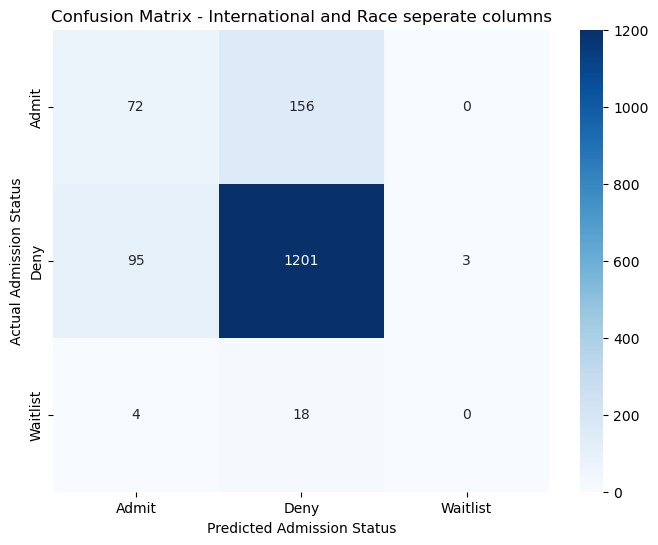

In [41]:
def confusionMatrix(y_pred, y_test, title):
    # Reverse factorize (converting y_pred from 0s,1s and 2s to Accept, Deny and Waitlist
    reversefactor = dict(zip(range(3),definitions))
    y_test_labels = np.vectorize(reversefactor.get)(y_test)
    y_pred_labels = np.vectorize(reversefactor.get)(y_pred)

    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Precision: {precision}\nRecall: {recall}\nF1 Score: {f1}")

    # Generate the confusion matrix
    cm = confusion_matrix(y_test_labels, y_pred_labels, labels=definitions)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=definitions, yticklabels=definitions)
    plt.xlabel("Predicted Admission Status")
    plt.ylabel("Actual Admission Status")
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

confusionMatrix(y_pred, y_test, 'International and Race seperate columns')

Precision: 0.8005312754085546
Recall: 0.8244028405422853
F1 Score: 0.8089982393990645


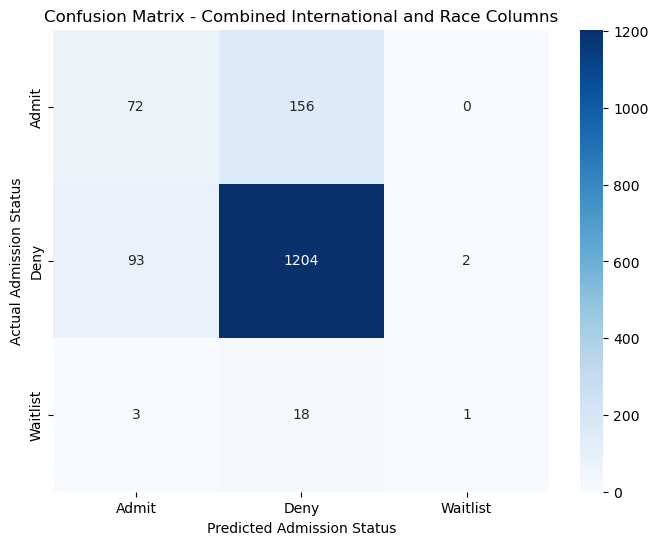

In [42]:
confusionMatrix(y_pred2, y2_test, 'Combined International and Race Columns')

# Hyperparameter Tuning

In [43]:
# Hyperparameter turning for the model with seperate international and race columns

f1_scorer = make_scorer(f1_score, average='weighted')  # Since high class imbalance, we don't want to use accuracy

param_grid = {
    'n_estimators': [5, 7, 10, 15, 20, 30, 40, 50, 100, 150, 200]
}

tree = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, scoring=f1_scorer, cv=5, verbose=2, n_jobs=-1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)


Fitting 5 folds for each of 11 candidates, totalling 55 fits
Best Parameters: {'n_estimators': 10}
Best Cross-Validation Accuracy: 0.8018921229066329


In [44]:
# Hyperparameter turning for the model with combined international and race columns

tree2 = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search2 = GridSearchCV(estimator=tree2, param_grid=param_grid, scoring=f1_scorer, cv=5, verbose=2, n_jobs=-1)

# Perform grid search
grid_search2.fit(X2_train, y2_train)

# Best parameters and best score
print("Best Parameters:", grid_search2.best_params_)
print("Best Cross-Validation Accuracy:", grid_search2.best_score_)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Best Parameters: {'n_estimators': 20}
Best Cross-Validation Accuracy: 0.8005650970655733


Since we previous RF classifiers already used n_estimators = 10, I will not train another model for X_train as the best hyperparamter was used

Precision: 0.798476047279811
Recall: 0.8315041962556488
F1 Score: 0.8089370699556808


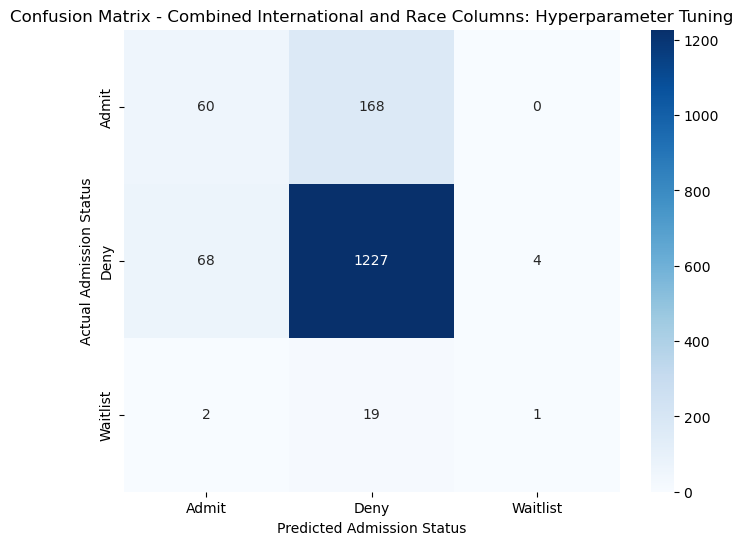

In [45]:
# Testing best param for combined attributes dataset
RFClassifier_CombinedIntandRace_BestParam = RandomForestClassifier(n_estimators = grid_search2.best_params_['n_estimators'], criterion = 'entropy', random_state = 42)
RFClassifier_CombinedIntandRace_BestParam.fit(X2_train, y2_train)

y2_pred_BestParam = RFClassifier_CombinedIntandRace_BestParam.predict(X2_test)

confusionMatrix(y2_pred_BestParam, y2_test, 'Combined International and Race Columns: Hyperparameter Tuning')
